In [1]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

df = pd.read_csv('sample_data/structure_dataset.csv', sep='\t')

# Data Cleaning
show some statistics on imported dataset



In [2]:
print("Number of null elements per column")
print(df.isna().sum())
print("\nPercentage of null elements per column")
print(df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0])

Number of null elements per column
ID                        0
PROVINCIA                 0
COMUNE                    0
LOCALITA               6208
CAMERE                    0
SUITE                     0
LETTI                     0
BAGNI                     0
PRIMA_COLAZIONE           0
IN_ABITATO              107
SUL_LAGO                107
VICINO_ELIPORTO         107
VICINO_AEREOPORTO       107
ZONA_CENTRALE           107
VICINO_IMP_RISALITA     107
ZONA_PERIFERICA         107
ZONA_STAZIONE_FS        107
ATTREZZATURE_VARIE     2759
CARTE_ACCETTATE        4705
LINGUE_PARLATE         3680
SPORT                  6168
CONGRESSI              6468
LATITUDINE               47
LONGITUDINE              47
OUTPUT                    0
dtype: int64

Percentage of null elements per column
LOCALITA               91.630996
IN_ABITATO              1.579336
SUL_LAGO                1.579336
VICINO_ELIPORTO         1.579336
VICINO_AEREOPORTO       1.579336
ZONA_CENTRALE           1.579336
VICINO_IMP_RIS

In [3]:
# drop column
useless_column = ['COMUNE', 'LOCALITA', 'LATITUDINE', 'LONGITUDINE']
# replace all nan with 0
default_zero = ['VICINO_ELIPORTO', 'VICINO_AEREOPORTO', 'VICINO_IMP_RISALITA',
                'SUL_LAGO', 'CONGRESSI']
# replace all nan with 'Non pervenuto'
missing = ['CARTE_ACCETTATE']
# replace following its own distribution
own_distribution = ['IN_ABITATO', 'ZONA_STAZIONE_FS']
# same last plus avoid intersection
zona = ['ZONA_CENTRALE', 'ZONA_PERIFERICA']
# count the number of elements
n_elem = ['LINGUE_PARLATE', 'SPORT', 'ATTREZZATURE_VARIE']

In [4]:
def replace_NaN_with_distributions(columns: list, values = [0.0, 1.0], dependent=False):
    """ 
    find the probability of each element of the given column
    and replace the missing value with that probability
    @dependent = False means cannot be intersections
    """
    for i, c in enumerate(columns):
        tmp_df = df[df[c].notnull()]
        if df[c].isna().sum() == 0:
            print("NOTHING TO CHANGE")
            return

        values = df[df[c].notna()][c].unique()
        probability = tmp_df.groupby(c).size().div(len(tmp_df))
        lambda_prob = lambda v: random.choices(values, probability)[0]
        if i > 0 and dependent:
            df[c] = df[df[columns[:i-1]].notna()][c].isna().apply(lambda_prob)
        else:
            df[c] = df[c].isna().apply(lambda_prob)

def replace_NaN_with(column, value = 0):
    df[column] = df[column].fillna(value)

def find_n_elements(string) -> int:
    if type(string) != str:
        return
    return len(string.split(","))

def replace_with_count(columns: list):
    """
    For each element in the given list count the number of elements splitted
    by ','
    """
    for i, c in enumerate(columns):
        df[c] = df[df[c].notna()][c].apply(find_n_elements)
        replace_NaN_with(c, 0)

def get_congressi_numbers(string):
    """
    return the number related to congress rooms
    """
    return int(string.split(",")[0].split(" ")[3])

*   Remove useless colums ('COMUNE', 'LOCALITA', 'LATITUDINE', 'LONGITUDINE' has
too sparse data)
*   Handle NaN value:
    *   replace with '0' if number or 'Non pervenuto' data that are too hard to guess
(such as 'SPORT' and 'ATTREZZATURE_VARIE')

    *   with few sample missing replace data by using the distribution found by the given examples. In same cases seems useful keep only one value between different columns and this is performed by setting the parameter @dependent=True.

* Convert data: for some columns such as 'LINGUE_PARLATE' are more useful to calculate the number of elements than to have the elements themselves

* Get the information from the string it self ('CONGRESSI' has the more important information inside the string, and would be useless encode all that string combinations)


In [5]:
#@title Cleaning
df = df.drop(columns=useless_column)

In [6]:
df['CONGRESSI'] = df.loc[df['CONGRESSI'].notna(), 'CONGRESSI'].apply(get_congressi_numbers)

replace_NaN_with('LINGUE_PARLATE', 1)
replace_NaN_with(default_zero, 0)
replace_NaN_with(missing, 'Non pervenuto')
replace_NaN_with_distributions(own_distribution)
replace_NaN_with_distributions(zona, dependent=True)
replace_with_count(n_elem)

df.loc[(df['CARTE_ACCETTATE'].str.contains("Tutte")) & (df['CARTE_ACCETTATE'].notna()), 'CARTE_ACCETTATE'] = 'Alcune'
df.loc[df['CARTE_ACCETTATE'].str.contains("Tutte"), 'CARTE_ACCETTATE'] = 'Tutte'



*   encoding variables that aren't numbers
*   create train and test set in order to train some models




In [7]:
#@title Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def int_encoding(column):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(df[column])

def binary_encoding(column):
    integer_encoded = int_encoding(column)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    return onehot_encoder.fit_transform(integer_encoded)

In [8]:
df['PROVINCIA'] = binary_encoding('PROVINCIA')
df['CARTE_ACCETTATE'] = binary_encoding('CARTE_ACCETTATE')

In [9]:
X = df.drop(columns=['OUTPUT'])
Y = df['OUTPUT']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

# Plotting

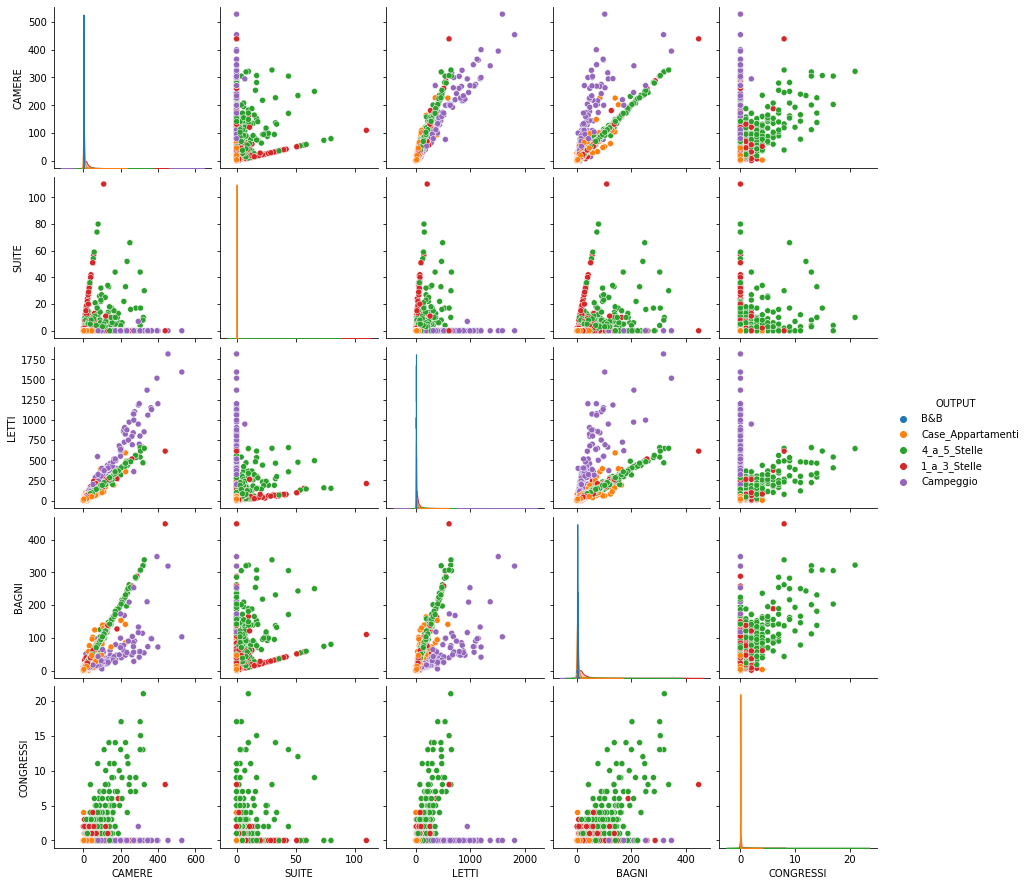

In [10]:
import seaborn as sns

pair = df[['CAMERE', 'SUITE', 'LETTI','BAGNI','CONGRESSI', 'OUTPUT']]
sns.pairplot(pair, hue='OUTPUT')

# Training

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def find_best_params(possibilities, estimator):
    """
    return the best parameter for the given combinations
    """
    GS = GridSearchCV(
            estimator=estimator,
            param_grid=possibilities,
            #refit='AUC',
            cv=5
        )
    search = GS.fit(x_train, y_train)
    print("Best params:", search.best_params_)
    return search.best_params_
  
def find_accuracy(model):
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    model_name = type(model).__name__
    accuracy = accuracy_score(y_test, prediction)
    return (model_name, accuracy, prediction)

In [12]:
mlp_params = {
    'max_iter':(600, 800), 
    'hidden_layer_sizes':[(3,3), (4,4), (5,5), (5,5,5)],
    'activation':['relu', 'logistic']
}

svc_params = {
    'kernel':('rbf', 'sigmoid'), 
    'C':[10, 1, 50]
}

rfc_params = {
    'n_estimators': (10, 50, 100),
    'criterion' : ('gini', 'entropy')
}

*   Defining different models that leverage supervised learning to perform classification:
  1.   *Support Vector Classification*
  2.   *Random Forest*
  3.   *Multilayer Perceptrons*
*   Search the best parameters for each model trough "GridSearch".
*   Then find the model with the highest accuracy

Models are saved globally in order to reduce the time required for the next tests on modified data

In [13]:
class Model:
  def __init__(self, name="", score=0, prediction=[]):
    self.name = name
    self.score = score
    self.prediction = prediction

In [14]:
#@title Find the best model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

svc_model = svm.SVC(**find_best_params(svc_params, svm.SVC()))
rf_model = RandomForestClassifier(
    **find_best_params(rfc_params, RandomForestClassifier())
)
mlp_model = MLPClassifier(**find_best_params(mlp_params, MLPClassifier()))
models = [rf_model, svc_model, mlp_model]

def find_best_model(models):
  best_model = Model()

  for model in models:
      name, accuracy, prediction = find_accuracy(model)
      accuracy = round(accuracy, 3)
      print("Model:", name, "with accuracy:", accuracy)
      if accuracy > best_model.score:
          best_model = Model(
              name=name, 
              score=accuracy, 
              prediction=prediction
              )

  print("\nBest model is:", best_model.name, "with accuracy:", best_model.score)
  return best_model

Best params: {'C': 50, 'kernel': 'rbf'}
Best params: {'criterion': 'entropy', 'n_estimators': 100}
Best params: {'activation': 'logistic', 'hidden_layer_sizes': (4, 4), 'max_iter': 600}


In [15]:
best_model = find_best_model(models)

Model: RandomForestClassifier with accuracy: 0.81
Model: SVC with accuracy: 0.572
Model: MLPClassifier with accuracy: 0.58

Best model is: RandomForestClassifier with accuracy: 0.81


Some more clear rappresentation of the results with the confusion matrix

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

output_names = [*df['OUTPUT'].unique()]

def show_confusion_matrix(y_test, prediction):
  print("Confusion matrix")
  cm = confusion_matrix(y_test, prediction, labels=output_names)
  hm_cm = ConfusionMatrixDisplay(cm, display_labels=output_names)
  fig, ax = plt.subplots(figsize=(10,10))
  hm_cm.plot(ax=ax, cmap='BuGn')

Confusion matrix


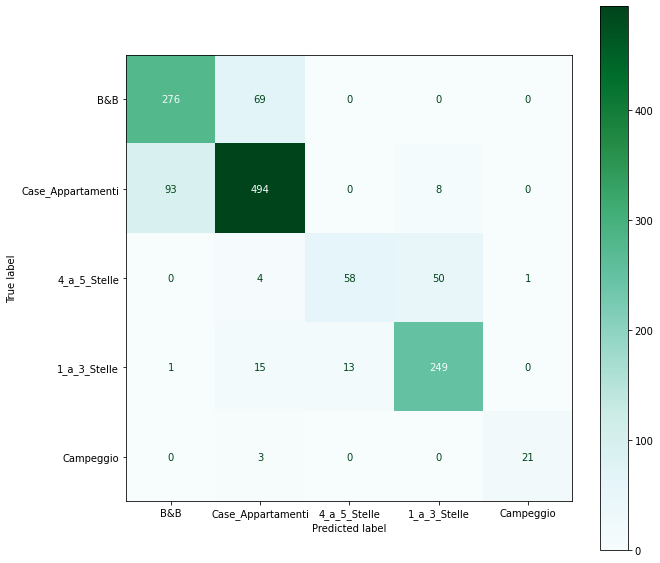

In [17]:
show_confusion_matrix(y_test, best_model.prediction)

## Other tests reducing the number of columns

In [18]:
useless_column_new = ['IN_ABITATO', 'SPORT', 'ATTREZZATURE_VARIE', 'CONGRESSI']
df = df.drop(columns=useless_column_new)
best_model = find_best_model(models)

Model: RandomForestClassifier with accuracy: 0.81
Model: SVC with accuracy: 0.572
Model: MLPClassifier with accuracy: 0.731

Best model is: RandomForestClassifier with accuracy: 0.81


Model: RandomForestClassifier with accuracy: 0.813
Model: SVC with accuracy: 0.572
Model: MLPClassifier with accuracy: 0.717

Best model is: RandomForestClassifier with accuracy: 0.813
Confusion matrix


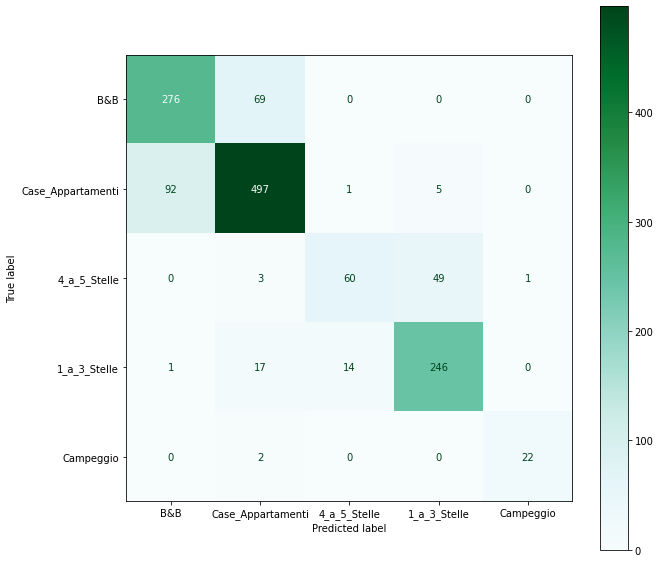

In [19]:
useless_column_new = ['VICINO_ELIPORTO', 'VICINO_AEREOPORTO', 'VICINO_IMP_RISALITA', 'CARTE_ACCETTATE']
df = df.drop(columns=useless_column_new)
best_model = find_best_model(models)
show_confusion_matrix(y_test, best_model.prediction)

Model: RandomForestClassifier with accuracy: 0.811
Model: SVC with accuracy: 0.572
Model: MLPClassifier with accuracy: 0.715

Best model is: RandomForestClassifier with accuracy: 0.811
Confusion matrix


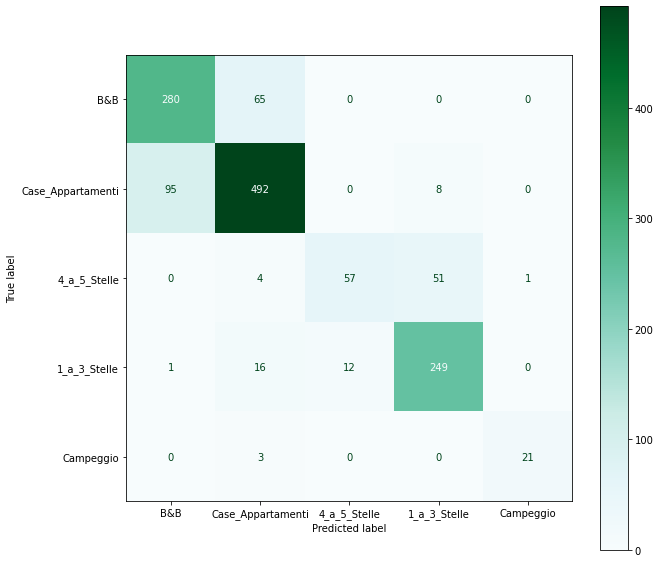

In [20]:
df = df.drop(columns=zona)
best_model = find_best_model(models)
show_confusion_matrix(y_test, best_model.prediction)